In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

In [4]:
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/simple-straight-120.mid
 [INFO] : 
 |  reading file: ../datasets/examples/simple-shuffle-120.mid

Encoding midi-data
 [<midi file '../datasets/examples/simple-straight-120.mid' type 0, 1 tracks, 68 messages>, <midi file '../datasets/examples/simple-shuffle-120.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 1)


In [5]:
n = 1000
min_f = -4 # normalized to 0
max_f = 4
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=2,
    n_channels=4,
    d_phase=False,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 4)


In [6]:
x_train.shape

(1000, 100, 4, 1)

In [7]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(1000, 100, 4, 1), 900]

In [8]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 4)


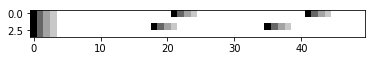

m (50, 4)


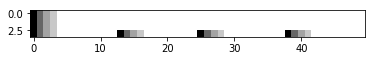

m (50, 4)


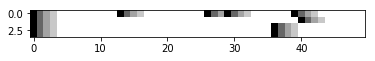

In [9]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])

In [10]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(100, 4, 1)

In [11]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [62]:
def encoder(input_size, dropout=0.1):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    #     x = AveragePooling2D((2, 2))(x)
#     h = Conv1D(128, kernel_size=2, strides=2, activation='relu', padding='same')(h)

    # Dense layers
    h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dense(intermediate_dim, activation='relu')(h)
    # h = Dense(intermediate_dim, activation='relu', kernel_regularizer=k_reg, activity_regularizer=a_reg)(h)
    
#     x = Reshape((-1, 1, 1))(x)

    h = Reshape((-1, intermediate_dim))(h)
    n_capsules = 10
    capsule_dim = 10
    n_routings = 3
    share_weights = True
    h = Capsule(n_capsules, capsule_dim, n_routings, share_weights)(h)

    # h = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(h)
    h = Reshape((n_capsules * capsule_dim,))(h)
    
    # Z Mean, Variance - no activation? TODO
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'

    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [63]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

shared weights, shape = (1, 128, 100) 12800
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 4, 1)    0                                            
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 100, 4)       0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 50, 32)       288         reshape_9[0][0]                  
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 50, 32)       2080        conv1d_9[0][0]                   
_________________________________________________________________

In [64]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [65]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [66]:
def list_decoders(output_shape, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_shape
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(intermediate_dim * 2, activation='relu') ]
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]
#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolution
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#    # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    # h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()]
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [67]:
decoders = list_decoders(input_shape)

In [68]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [69]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 4, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 232916      input_4[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          384         lambda_4[0][0]                   
__________

In [70]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=0.2)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_12" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_12" during training.
  # This is added back by InteractiveShellApp.init_path()


In [71]:
# train the VAE on MNIST digits
# (x_train, _), (x_test, y_test) = mnist.load_data()

In [72]:
x_train.shape

(900, 100, 4, 1)

In [73]:
print('x_train.shape:', x_train.shape)

x_train.shape: (900, 100, 4, 1)


In [74]:
batch_size = 100
epochs = 100
params = {'batch_size': batch_size, 'return_y': False}

In [86]:
phase_mod = 0.01
whitening = False

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by dataset std
#         samplewise_std_normalization=False,  # divide each input by its std
# #         zca_epsilon=10,
#         zca_whitening=whitening,
#         rotation_range=0,  # randomly rotate images in 0 to 180 degrees
#         width_shift_range=0.,  # note-channel mod, but not shuffled
#         height_shift_range=phase_mod,  # start_t, phase
#         horizontal_flip=False,  # reverse
#         vertical_flip=False)

# # datagen.fit(x_train)

In [76]:
m = 4
useDataGenerator = False
useDataGenerator = True

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>>>>\n' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=1)
            for k,v in h.history.items(): 
                history[k].append(v)
            if batch_i >= n_batches:
                break
#     history = vae.fit_generator(
#         X, epochs=epochs, steps_per_epoch=X.__len__(),
#         use_multiprocessing=True, workers=2,
#         validation_data=(x_test, None))
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100

[Epoch 0] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 1s 182ms/step - loss: 277.3126
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 267.2924
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 264.0650
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 224.9002
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 199.7906
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 141.7092
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 117.6872
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 103.7114
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 101.6697
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 80.2831

[Epoch 1] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [================

4/4 [==============================] - 0s 3ms/step - loss: 57.9730
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 61.4815
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 62.1479
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 57.2593
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 60.5888
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 61.8618
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 64.4788
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 56.3942
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 64.5958
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 58.2789

[Epoch 10] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 69.0306
 Batch 1/9
Epoch 1/1
4/4 [=

 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 58.8721
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 61.0415
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 64.6918
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 56.5710
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 61.2951
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 59.2200
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 65.7769
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 58.8734
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 59.9820

[Epoch 19] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 60.0926
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 64.7457
 Batch

 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 48.6697
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 67.2098
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 66.5406
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 55.3182
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 59.9249
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 54.1836
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 47.7328
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 57.8741

[Epoch 28] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 50.3267
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 62.3277
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 60.2803
 Batch

 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 56.3905
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 49.3610
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 5ms/step - loss: 62.6001
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 59.9271
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 52.4531
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 47.7916
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 51.7210

[Epoch 37] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 53.2572
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 53.0411
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 56.4704
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 62.6351
 Batch

 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 50.0225
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 53.7021
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 5ms/step - loss: 55.6458
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 62.1270
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 50.4093
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 65.9622

[Epoch 46] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 49.2354
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 50.4284
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 60.8507
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 50.5852
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 64.0104
 Batch

 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 48.5062
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 49.9401
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 45.8681
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 48.6311
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 45.5735

[Epoch 55] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 47.1235
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 48.2383
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 46.5159
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 45.6792
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 50.3697
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 46.0975
 Batch

 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 51.4047
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 51.4893
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 49.4211
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 46.5221

[Epoch 64] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 49.8966
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 51.6468
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 55.3922
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 69.1078
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 53.1884
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 49.2937
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 49.6132
 Batch

 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 53.5533
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 46.9683
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 45.9521

[Epoch 73] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 46.8152
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 52.1311
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 218.1060
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 128.3347
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 119.0227
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 109.5667
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 80.9588
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 73.4833
 B

 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 54.4704
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 47.0459

[Epoch 82] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 49.9811
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 45.1824
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 48.3340
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 5ms/step - loss: 46.8682
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 49.8595
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 52.9657
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 51.1057
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 50.2763
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 7ms/step - loss: 58.8117
 Batch

 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 45.6561

[Epoch 91] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 51.6643
 Batch 1/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 43.3965
 Batch 2/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 44.3160
 Batch 3/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 44.7767
 Batch 4/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 50.6898
 Batch 5/9
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 49.8436
 Batch 6/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 52.9252
 Batch 7/9
Epoch 1/1
4/4 [==============================] - 0s 2ms/step - loss: 47.6384
 Batch 8/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 47.2850
 Batch 9/9
Epoch 1/1
4/4 [==============================] - 0s 3ms/step - loss: 47.4756

[Epoc

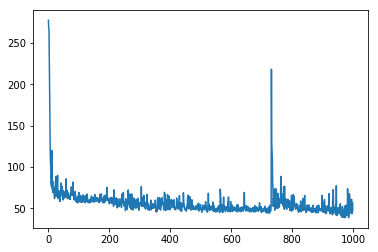

In [77]:
# x = epochs * batches
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [85]:
# datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
# x = datagen.standardize(x_train[:10])
# i = 0
# plot.single(x_train[i, :50, :, 0])
# plot.single(x[i, :50, :, 0])

m (50, 4)


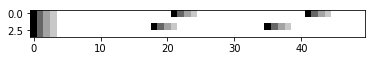

m (50, 4)


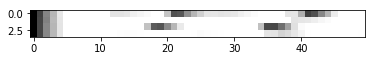

m (50, 4)


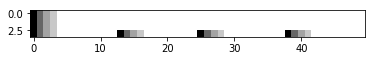

m (50, 4)


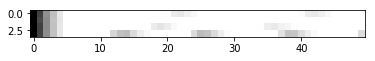

In [87]:
i = 0
j = 1
x = vae.predict(x_train[:10])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])

In [59]:
x.shape

(10, 100, 4, 1)

m (30, 4)


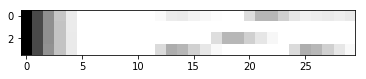

In [60]:
# interpolate - mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

m (30, 4)


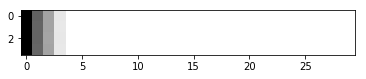

In [31]:
# interpolate - min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [32]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [33]:
x_test.shape

(100, 100, 4, 1)

In [34]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 2)

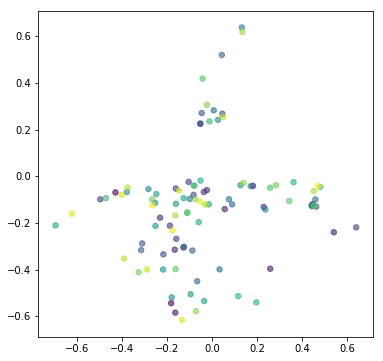

In [35]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_test, alpha=0.6, s=30)

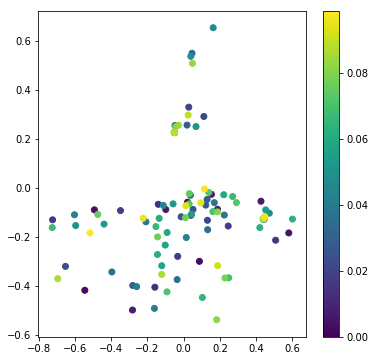

In [36]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [37]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [38]:
# x_decoded[0].reshape(150,3)

In [39]:
# display a 2D manifold of the digits
n = 3  # figure with 15x15 digits
digit_size1 = x_decoded.shape[-2]
digit_size2 = x_decoded.shape[-1]
figure = np.zeros((digit_size1 * n, digit_size1 * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size1, digit_size2)
        figure[i * digit_size1: (i + 1) * digit_size1,
               j * digit_size2: (j + 1) * digit_size2] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

NameError: name 'x_decoded' is not defined